code copied from 'Predicting Crypto Prices in Python' [https://youtu.be/GFSiL6zEZF0]

## import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## load data

In [2]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2018,6, 1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-05-31,7604.729980,7407.339844,7500.700195,7541.450195,4.921460e+09,7541.450195
2018-06-01,7695.830078,7497.259766,7536.720215,7643.450195,4.939300e+09,7643.450195
2018-06-02,7754.890137,7613.040039,7632.089844,7720.250000,4.851760e+09,7720.250000
2018-06-03,7753.819824,7474.040039,7722.529785,7514.470215,4.993170e+09,7514.470215
2018-06-04,7643.229980,7397.000000,7500.899902,7633.759766,4.961740e+09,7633.759766
...,...,...,...,...,...,...
2021-06-21,33292.453125,28893.621094,31622.376953,32505.660156,5.896435e+10,32505.660156
2021-06-22,34753.410156,31772.632812,32515.714844,33723.027344,4.631711e+10,33723.027344
2021-06-23,35228.851562,32385.214844,33682.800781,34662.437500,3.312337e+10,34662.437500


## Prepare Data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create Neural Network

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Train on 1028 samples
Epoch 1/25
1028/1028 [==============================] - 7s 7ms/sample - loss: 0.0225
Epoch 2/25
1028/1028 [==============================] - 2s 2ms/sample - loss: 0.0111
Epoch 3/25
1028/1028 [==============================] - 2s 2ms/sample - loss: 0.0094
Epoch 4/25
1028/1028 [==============================] - 2s 2ms/sample - loss: 0.0095
Epoch 5/25
1028/1028 [==============================] - 2s 2ms/sample - loss: 0.0091
Epoch 6/25
1028/1028 [==============================] - 2s 2ms/sample - loss: 0.0089
Epoch 7/25
1028/1028 [==============================] - 3s 2ms/sample - loss: 0.0070
Epoch 8/25
1028/1028 [==============================] - 2s 2ms/sample - loss: 0.0063
Epoch 9/25
1028/1028 [==============================] - 3s 3ms/sample - loss: 0.0050
Epoch 10/25
1028/1028 [==============================] - 3s 3ms/sample - loss: 0.0056
Epoch 11/25
1028/1028 [==============================] - 3s 3ms/sample - loss: 0.0049
Epoch 12/25
1028/1028 [==================

## Testing the model

In [6]:
test_start = dt.datetime(2020, 6, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

## Plot test data

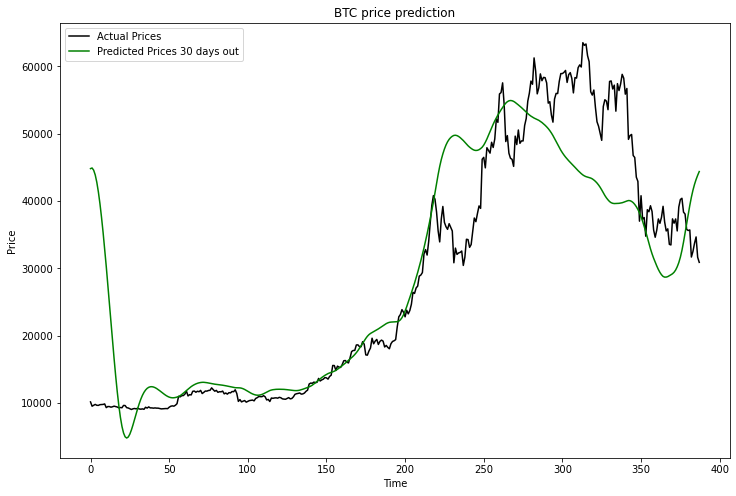

In [9]:
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color="black", label='Actual Prices')
plt.plot(prediction_prices, color="green", label='Predicted Prices 30 days out')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## Predict next day

In [8]:
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[44805.316]]
